In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers.experimental import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
from tqdm import tqdm

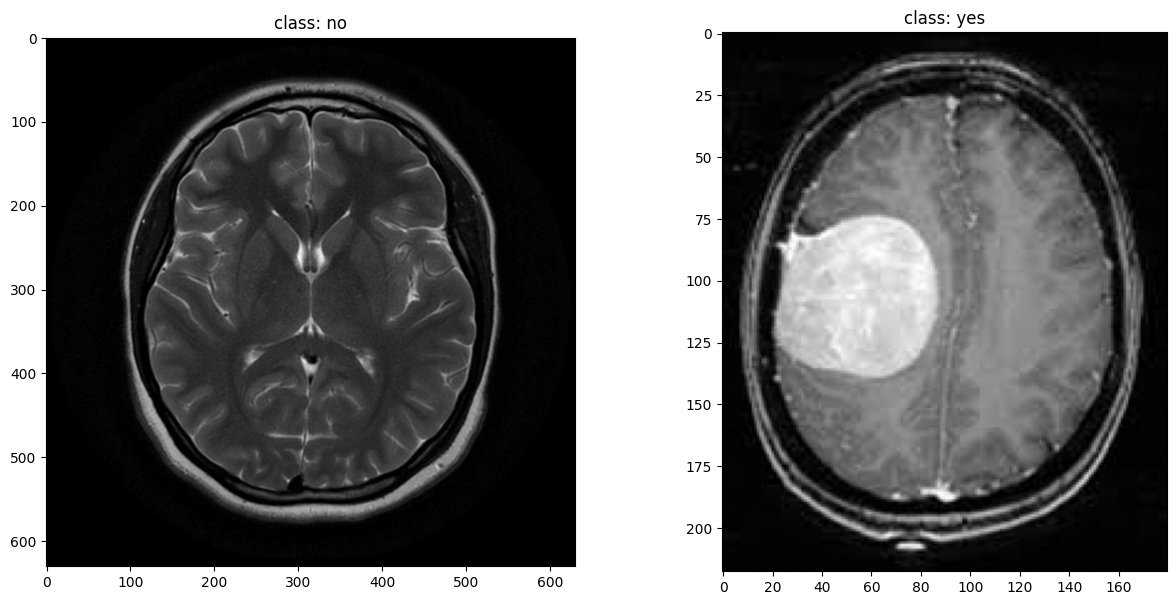

In [5]:
categories = ["no","yes"]
directory = "/content/drive/MyDrive/Brain"
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
for idx,category in enumerate(categories):
    new_dir = os.path.join(directory,category)
    for image in os.listdir(new_dir):
        img_arr = cv2.imread(os.path.join(new_dir,image))
        ax[idx].imshow(img_arr)
        ax[idx].title.set_text(f"class: {category}")
        break
plt.show()

In [8]:
data = []
for idx,category in tqdm(enumerate(categories)):
    new_dir = os.path.join(directory,category)
    for image in os.listdir(new_dir):
        img_arr = cv2.imread(os.path.join(new_dir,image))
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        img_resize = cv2.resize(img_arr,(224,224))
        data.append([img_resize,idx])

2it [00:04,  2.06s/it]


In [9]:
for x, y in data:
    print(x.shape)
    break

(224, 224, 3)


In [10]:
check_sample=[]
for sample in data:
    check_sample.append(sample[1])
    check_first10 = check_sample[:10]
    check_last10 = check_sample[-10:]

print(f'{check_first10}\n{check_last10}')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
zeros = []
ones = []
for sample in data:
    test = sample[1]
    if test==1:
        ones.append(test)
    else:
        zeros.append(0)

print(f'There are {len(zeros)} \'no\' cases')
print(f'There are {len(ones)} \'yes\' cases')

There are 98 'no' cases
There are 156 'yes' cases


In [12]:
# data = data[:(196)]

In [13]:
zeros = []
ones = []
for sample in data:
    test = sample[1]
    if test==1:
        ones.append(test)
    else:
        zeros.append(0)

print(f'There are {len(zeros)} \'no\' cases')
print(f'There are {len(ones)} \'yes\' cases')

There are 98 'no' cases
There are 156 'yes' cases


In [14]:
import random
random.shuffle(data)

In [15]:
check_sample=[]
for sample in data:
    check_sample.append(sample[1])
check_first10 = check_sample[:10]
check_last10 = check_sample[-10:]

print(f'{check_first10}\n{check_last10}')

[0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
[1, 1, 1, 1, 0, 1, 1, 1, 1, 0]


In [16]:
X_train = []
y_train = []
for arr, cat in data:
    X_train.append(arr)
    y_train.append(cat)
X_train = np.array(X_train).reshape(-1, 224,224, 3)
y_train = np.array(y_train)

In [17]:
train_gen = ImageDataGenerator(
                               rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode="nearest",
                               validation_split=0.2
                                    )
val_gen = ImageDataGenerator(
                             rescale=1./255, 
                             validation_split=0.2,
                                    )
train_data = train_gen.flow(
                                X_train,
                                y_train,
                                batch_size=32,
                                seed=123,
                                subset="training",
                                    )
val_data = val_gen.flow(
                                X_train,
                                y_train,
                                batch_size=16,
                                seed=123,
                                subset="validation"
                                    )

### Visualizing first batch in the training data, just to confirm that images have been augumented

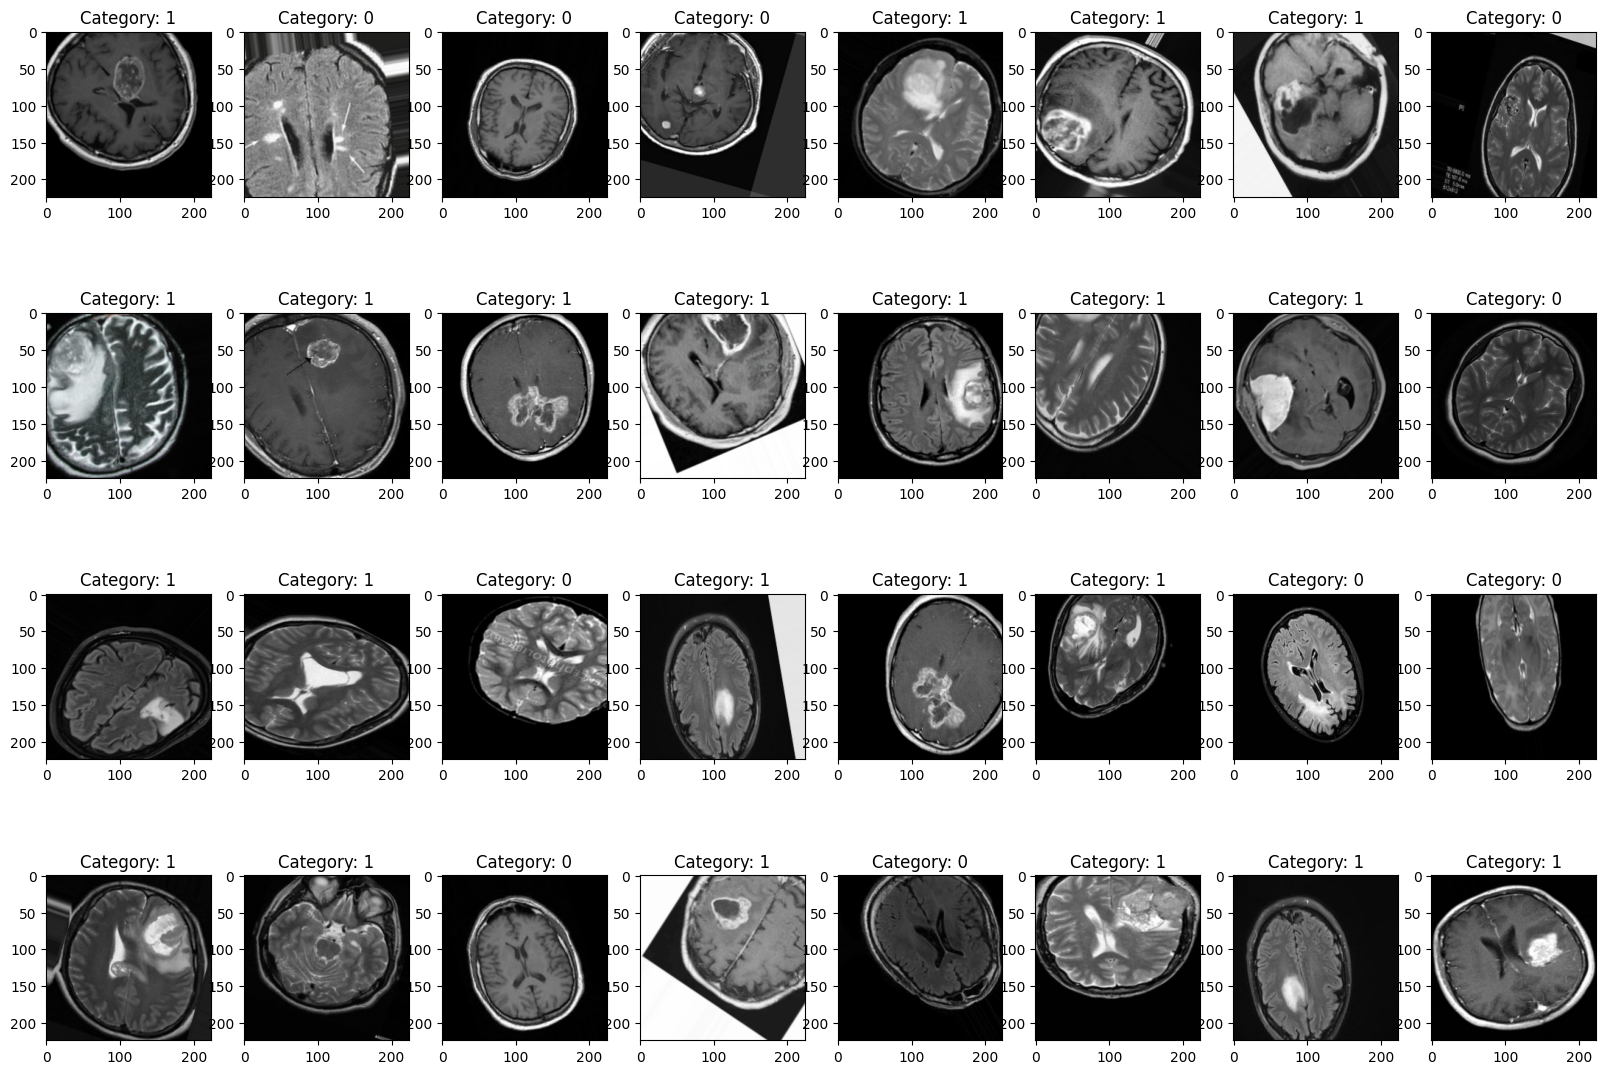

In [18]:
plt.figure(figsize=(20,14))
batch_to_plot = next(train_data)
for idx, array in enumerate(batch_to_plot[0], start=1):
    plt.subplot(4,8,idx)
    plt.imshow(array)
    plt.title(f"Category: {batch_to_plot[1][idx-1]}")
    
plt.show()


### Visualizing first batch in the validation data, just to confirm that image were not augumented

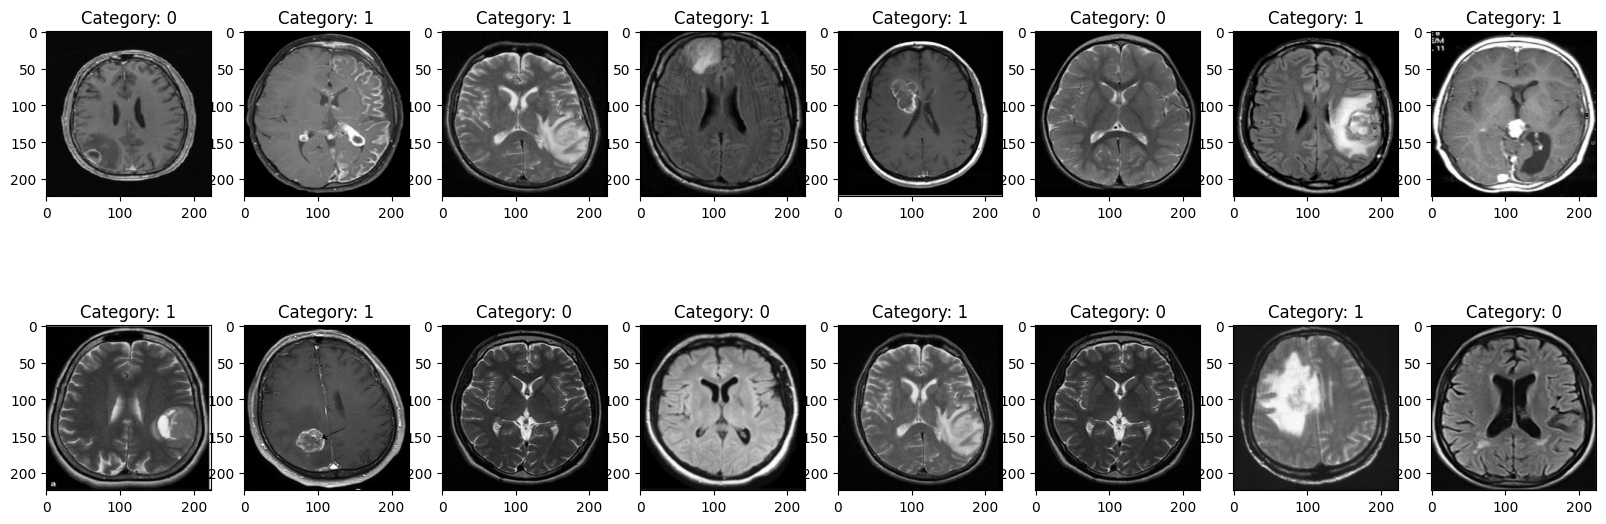

In [19]:
plt.figure(figsize=(20,7))
val_batch_to_plot = next(val_data)
for idx, array in enumerate(val_batch_to_plot[0], start=1):
    plt.subplot(2,8,idx)
    plt.imshow(array)
    plt.title(f"Category: {val_batch_to_plot[1][idx-1]}")
    
plt.show()


In [21]:
base_model = VGG16(
    weights=os.path.join(directory, "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"),
    include_top=False, 
    input_shape=(224, 224) + (3,)
)

base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Dense(128, activation="relu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense (Dense)               (None, 7, 7, 128)         65664     
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 14,786,625
Trainable params: 71,937
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
es = EarlyStopping(
    monitor="val_accuracy", 
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
                                    train_data,
                                    steps_per_epoch=train_data.n // train_data.batch_size,
                                    validation_data=val_data,
                                    validation_steps=val_data.n // val_data.batch_size,
                                    epochs=30,
                                    # callbacks=es
                    )

Epoch 1/30
6/6 [==============================] - 100s 17s/step - loss: 0.7314 - accuracy: 0.5781 - val_loss: 0.6040 - val_accuracy: 0.7708
Epoch 2/30
6/6 [==============================] - 86s 15s/step - loss: 0.6721 - accuracy: 0.6337 - val_loss: 0.5619 - val_accuracy: 0.7083
Epoch 3/30
6/6 [==============================] - 89s 15s/step - loss: 0.6150 - accuracy: 0.6279 - val_loss: 0.5402 - val_accuracy: 0.7500
Epoch 4/30
6/6 [==============================] - 86s 15s/step - loss: 0.6040 - accuracy: 0.6686 - val_loss: 0.5056 - val_accuracy: 0.7917
Epoch 5/30
6/6 [==============================] - 88s 16s/step - loss: 0.5841 - accuracy: 0.7035 - val_loss: 0.4811 - val_accuracy: 0.8125
Epoch 6/30
6/6 [==============================] - 91s 16s/step - loss: 0.5255 - accuracy: 0.7442 - val_loss: 0.4374 - val_accuracy: 0.8333
Epoch 7/30
6/6 [==============================] - 90s 15s/step - loss: 0.6124 - accuracy: 0.6919 - val_loss: 0.4372 - val_accuracy: 0.8125
Epoch 8/30
6/6 [==========

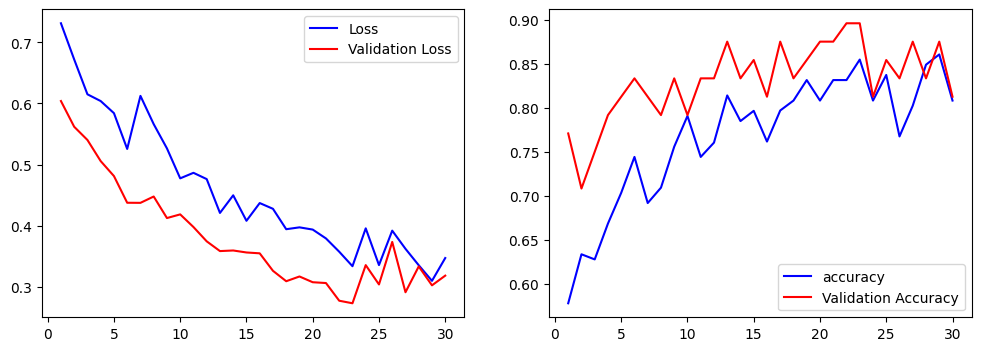

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,1+len(loss))
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4))
ax1.plot(epochs,loss,'b',label='Loss')
ax1.plot(epochs,val_loss,'r',label='Validation Loss')
ax1.legend()

ax2.plot(epochs,acc,'b',label='accuracy')
ax2.plot(epochs,val_acc,'r',label='Validation Accuracy')
ax2.legend()

plt.show()


In [25]:
def predict(image_directory):
    arr = cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
    arr_resize = cv2.resize(arr, (224, 224))
    plt.imshow(arr_resize)
    pred = model.predict(arr_resize)
    class_idx = int(pred)
    return f"Image belongs to class {categories[class_idx].upper()}"   

In [28]:
model.save("brain_mri.h5")